In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from pandas.plotting import scatter_matrix

Step 1: Loading data & testing/training split from Project 1

In [2]:
url = 'https://raw.githubusercontent.com/arianacodes/project-1/main/player_shooting_2023_2024.csv'
df = pd.read_csv(url, index_col=0)
#dropping columns that are repetative or not correlated: 
df = df.drop(['Age', 'Nation','Birth Month','Matches'],axis=1)
df = df[df['Squad'] != 'Squad']                           #removing rows that contained no data

#One Hot Encoding position and team
pos_array = pd.get_dummies(df.Pos)
squad_array = pd.get_dummies(df.Squad)
df = pd.concat([df,pos_array], axis=1)
df = pd.concat([df,squad_array], axis=1)
df = df.drop(['West Ham','GK','Pos','Squad'],axis=1) #dropping one and respective column (*2)

df['Exceeded xG'] = np.where(df['G-xG'] > 0, 1, 0)  #creating binary target attribute
df = df.drop(['Gls','xG','PK','FK','G/Sh','npxG','np:G-xG'],axis=1)    #dropping correlated variables

df['Exceeded xG'] = np.where(df['G-xG'] > 0, 1, 0)
X = df.drop(columns=['Player', 'Exceeded xG','G-xG'])
y = df['Exceeded xG']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size=0.2)

Step 2: Preparing data. 

In [3]:
#preforming smoothing to 0 values
X_train = X_train.replace(np.nan, 0)
X_train[['SoT%','PKatt']] = X_train[['SoT%','PKatt']] + 0.1
X_train[['Sh','SoT','SoT/90','Sh/90']] = X_train[['Sh','SoT','SoT/90','Sh/90']] + 0.1

#Performing log feature scaling to have more Gaussian distributions
transformed = X_train[['Sh','SoT','Sh/90','SoT/90']].transform(lambda x: np.log(x))

X_train = X_train.drop(['Sh','SoT','Sh/90','SoT/90'],axis=1)
X_train = pd.concat([X_train, transformed], axis=1)

#doing the same thing to X_test
#preforming smoothing to 0 values
X_test = X_test.replace(np.nan, 0)
X_test[['SoT%','PKatt']] = X_test[['SoT%','PKatt']] + 0.1
X_test[['Sh','SoT','SoT/90','Sh/90']] = X_test[['Sh','SoT','SoT/90','Sh/90']] + 0.1

#Performing log feature scaling to have more Gaussian distributions
transform = X_test[['Sh','SoT','Sh/90','SoT/90']].transform(lambda x: np.log(x))

X_test = X_test.drop(['Sh','SoT','Sh/90','SoT/90'],axis=1)
X_test = pd.concat([X_test, transform], axis=1)

print(X_test.head())
print(X_train.head())

      Rk    Born   90s  SoT%  G/SoT  Dist  PKatt  npxG/Sh     DF  DF,FW  ...  \
38    38  1997.0  18.9  32.0   0.53  17.0    0.1     0.10  False  False  ...   
450  434  1996.0   4.6   0.1   0.00  18.1    0.1     0.05   True  False  ...   
365  352  1993.0  11.3  50.1   0.50  12.3    0.1     0.14   True  False  ...   
297  287  1988.0   8.2  25.1   0.00  18.4    0.1     0.07  False  False  ...   
76    75  2003.0   7.4  20.1   0.00  20.6    0.1     0.05  False  False  ...   

     Manchester Utd  Newcastle Utd  Nott'ham Forest  Sheffield Utd  Tottenham  \
38            False          False            False          False      False   
450            True          False            False          False      False   
365           False          False            False          False      False   
297           False          False            False          False      False   
76            False          False            False           True      False   

     Wolves        Sh       SoT 

Step 3: My target attribute in my training set has no apparent shape, even if I were to transform it.

<Axes: >

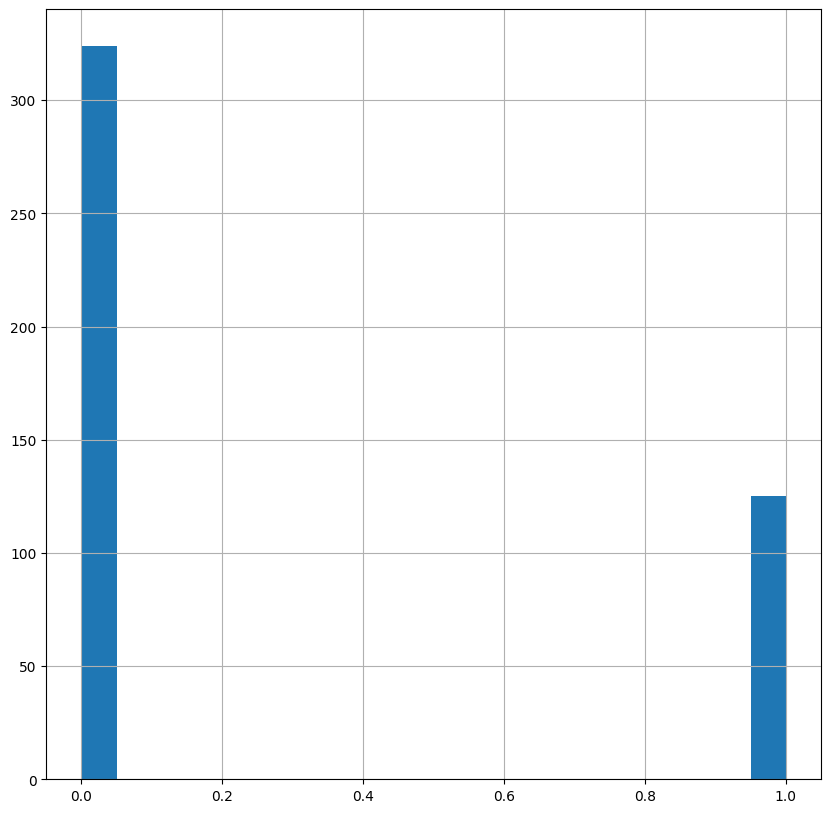

In [4]:
y_train.hist(bins = 20, figsize = (10,10))

Step 4: I am selecting Linear Regression and SVM

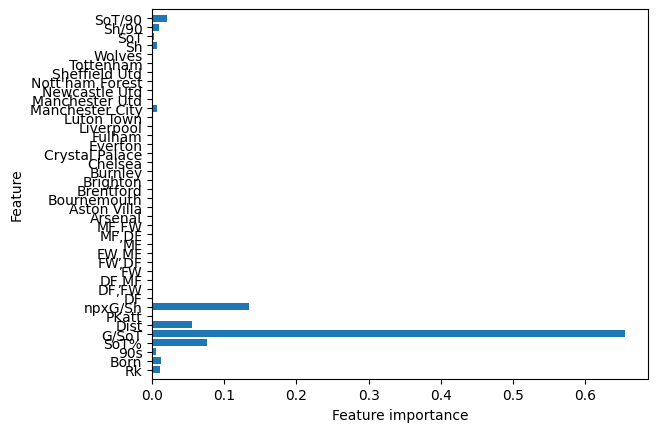

In [6]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances(gbrt)

Step 5: Here I run my two models a Gradient Boosting Classifier and K Nearest Neighbors. Below I report best and worst parameter settings for each model, calculate precision, recall, and F1 on default parameters and optimized parameters after using GridSearch. I also score

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=100, random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.938


In [6]:
from sklearn.metrics import classification_report

print(classification_report(y_test, gbrt.predict(X_test),
                            target_names=["Did not exceed xG", "Exceeded xG"]))

                   precision    recall  f1-score   support

Did not exceed xG       0.99      0.93      0.96        81
      Exceeded xG       0.84      0.97      0.90        32

         accuracy                           0.94       113
        macro avg       0.91      0.95      0.93       113
     weighted avg       0.94      0.94      0.94       113



In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=5)
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

recall = cross_val_score(gbrt, X, y, cv=kf, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(gbrt, X, y, cv=kf, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(gbrt, X, y, cv=kf, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.8627688172043012 [0.70967742 0.91666667 0.8125     0.875      1.        ]
Precision 0.8640289595462007 [0.78571429 0.91666667 0.78787879 0.93333333 0.89655172]
F1 0.8622219460874463 [0.74576271 0.91666667 0.8        0.90322581 0.94545455]


In [23]:
parameters = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    # "min_samples_split": np.linspace(0.1, 0.5, 12),
    # "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "n_estimators":[10, 50, 100, 200]
    }

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

grid = GridSearchCV(GradientBoostingClassifier(), parameters,cv=kf)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 8],
                         'n_estimators': [10, 50, 100, 200]})

In [29]:
pd.DataFrame(grid.cv_results_).iloc[:,5:].sort_values('rank_test_score')

,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.811111,0.933333,0.966667,0.966667,0.955056,0.926567,0.058997,1
37,3,50,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.811111,0.933333,0.955556,0.966667,0.955056,0.924345,0.057639,2
26,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.800000,0.944444,0.944444,0.966667,0.955056,0.922122,0.061610,3
38,3,100,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.800000,0.944444,0.944444,0.966667,0.955056,0.922122,0.061610,3
39,3,200,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.800000,0.933333,0.944444,0.955556,0.955056,0.917678,0.059399,5
27,3,200,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.788889,0.944444,0.944444,0.966667,0.943820,0.917653,0.064966,6
15,3,200,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.800000,0.944444,0.944444,0.944444,0.943820,0.915431,0.057716,7
14,3,100,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.788889,0.922222,0.955556,0.955556,0.943820,0.913208,0.063341,8
43,5,200,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.788889,0.933333,0.955556,0.944444,0.932584,0.910961,0.061611,9
42,5,100,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.800000,0.933333,0.933333,0.944444,0.932584,0.908739,0.054548,10


In [27]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

In [30]:
recall = cross_val_score(grid, X, y, cv=kf, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(grid, X, y, cv=kf, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(grid, X, y, cv=kf, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.8529397573752412 [0.70967742 0.94444444 0.8125     0.875      0.92307692]
Precision 0.8637404937404938 [0.78571429 0.91891892 0.78787879 0.93333333 0.89285714]
F1 0.8553617463372776 [0.74576271 0.93150685 0.8        0.87096774 0.92857143]


In [15]:
from sklearn.neighbors import KNeighborsClassifier
# k = 4
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(classification_report(y_test, gbrt.predict(X_test),
                            target_names=["Did not exceed xG", "Exceeded xG"]))

                   precision    recall  f1-score   support

Did not exceed xG       0.99      0.93      0.96        81
      Exceeded xG       0.84      0.97      0.90        32

         accuracy                           0.94       113
        macro avg       0.91      0.95      0.93       113
     weighted avg       0.94      0.94      0.94       113



In [16]:
recall = cross_val_score(knn, X, y, cv=kf, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(knn, X, y, cv=kf, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(knn, X, y, cv=kf, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.3579749103942652 [0.38709677 0.27777778 0.25       0.375      0.5       ]
Precision 0.4131049410359755 [0.4137931  0.41666667 0.36363636 0.5        0.37142857]
F1 0.3768861132795559 [0.4        0.33333333 0.2962963  0.42857143 0.42622951]


In [17]:
parameters_knn = {"n_neighbors" : [3, 5, 7, 9],
                "weights": ['uniform', 'distance'],
                "p" : [1, 1.5, 2]
                }

In [19]:
grid_knn = GridSearchCV(KNeighborsClassifier(), parameters_knn,cv=kf)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 1.5, 2],
                         'weights': ['uniform', 'distance']})

In [21]:
pd.DataFrame(grid_knn.cv_results_).iloc[:,4:].sort_values('rank_test_score')

,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,5,1,uniform,"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",0.688889,0.611111,0.688889,0.744444,0.719101,0.690487,0.044801,1
7,5,1,distance,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.666667,0.611111,0.688889,0.755556,0.685393,0.681523,0.046322,2
19,9,1,distance,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.655556,0.622222,0.666667,0.755556,0.685393,0.677079,0.044291,3
18,9,1,uniform,"{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}",0.677778,0.622222,0.655556,0.722222,0.696629,0.674881,0.034261,4
3,3,1.5,distance,"{'n_neighbors': 3, 'p': 1.5, 'weights': 'dista...",0.677778,0.600000,0.677778,0.733333,0.674157,0.672609,0.042463,5
17,7,2,distance,"{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}",0.666667,0.611111,0.677778,0.666667,0.719101,0.668265,0.034486,6
0,3,1,uniform,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.666667,0.622222,0.655556,0.688889,0.707865,0.668240,0.029249,7
8,5,1.5,uniform,"{'n_neighbors': 5, 'p': 1.5, 'weights': 'unifo...",0.677778,0.633333,0.666667,0.666667,0.696629,0.668215,0.020593,8
13,7,1,distance,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.644444,0.622222,0.655556,0.722222,0.696629,0.668215,0.036235,8
2,3,1.5,uniform,"{'n_neighbors': 3, 'p': 1.5, 'weights': 'unifo...",0.666667,0.588889,0.666667,0.733333,0.685393,0.668190,0.046547,10


The best parameters for my knn model are 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'. The worst are 'n_neighbors': 7, 'p': 1.5, 'weights': 'uniform'. The best parameters only improved my model by so much...

In [22]:
recall = cross_val_score(grid_knn, X, y, cv=kf, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(grid_knn, X, y, cv=kf, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(grid_knn, X, y, cv=kf, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.38396057347670254 [0.32258065 0.47222222 0.25       0.375      0.5       ]
Precision 0.4419668737060041 [0.41666667 0.56666667 0.33333333 0.52173913 0.37142857]
F1 0.40541906181250437 [0.36363636 0.51515152 0.28571429 0.43636364 0.42622951]
